# Calculations for Cooling and Detection Circuits

In [1]:
import numpy as np
import matplotlib.pyplot as plt
#from edes.utils import plotting as eplt
from edes.utils.plotting import plot, plot_ax
#from edes.utils.circuits import Component
import scipy.constants as spc
from tqdm import trange, tqdm
import scipy as sp

In [2]:
plt.rcParams['font.size'] = 13.5

## Design parameters

Trap
- trap drive $\omega_\mathrm{rf}$
- trap frequency $\omega_r, \omega_z$
- trap size $d_\mathrm{eff}$
- anharm $C_4/C_2$

Tank circuit
- quality factor $Q$
- frequency $\omega_t$

Detection circuit
- filtering
- dynamic range
- temperature $T$

## Basic components

### Fundamental constants

In [11]:
qe = -spc.e
e = spc.e
m = spc.m_e
kB = spc.k

### Circuit baics

In [8]:
def parallel(a, b):
    return 1/(1/a+1/b)

In [149]:
def W_to_dBm(W):
    return 10*np.log10(1000*W)

def dBm_to_W(dBm):
    return 10**(dBm/10)/1000

def dB_to_frac(dB):
    return 10**(dB/10)

def frac_to_dB(frac):
    return 10*np.log10(frac)

def voltage_noise_to_dBm(V, BW_meas=100, Z_meas=1e6):
    '''
    V/sqrt(Hz) to dBm converter
    V: V/sqrt(Hz); BW_meas: measurement bandwidth, in Hz; Z_measure: measurement impedance, in Ohm
    '''
    return W_to_dBm((V)**2*BW_meas/Z_meas)

In [4]:
class Component:
    """
    Base class for a circuit component used.
    """
    def __init__(self, name='Device', **kwargs):
        self.name = name
        for key in kwargs:
            setattr(self, key, kwargs[key])
    
    def H(self, omega):
        """
        Transfer function or frequency resoponse.
        V_out(omega) = H(omega)V_in(omega)
        
        Parameters
        ----------
        omega : ndarray
            Angular frequency.
        
        Returns
        -------
        H : ndarrar
            Linear circuit frequency response.
        """
        raise NotImplementedError
    
    def H_mag(self, omega):
        """
        Returns the magnitude of the frequency response.
        """
        return abs(self.H(omega))
    
    def get_noise(self, f):
        """
        Returns the power spectral density of the noise
        generated by the device.
        """
        return 0

    def white_noise(self, f, PSD):
        """
        Generate random white noise in freq domain 
        based on the length of f and the variance PSD.
        """
        return PSD * np.random.normal(1, 1, np.shape(f))
    
    def __call__(self, f, signal):
        """
        Returns the magnitude square of the output siganl given 
        input signal and frequencies.
        
        Parameters
        ----------
        f : ndarray
            Frequency in Hz
        signal : ndarray
            Values of the signal
        
        Returns
        -------
        V2_out : ndarray
            The magnitude of the output signal. Default assumes 
            linear frequency response, hence 
            |V_out|^2 = |H(omega)|^2 |V_in|^2
        noise : ndarray
            The noise psd of a given device.
        """
        omega = 2*np.pi*f
        return abs(signal)*self.H_mag(omega)**2

In [7]:
class BandPassFilter(Component):
    def __init__(self, omega_0, Q, name='BPF'):
        """
        A band-pass filter.
        
        Parameters
        ----------
        omega_0 : [rad/s]
            Resonant frequency of the filter, in angular frequency
        Q : float
            Quality factor
        """
        super().__init__(name=name, omega_0=omega_0, Q=Q)
    
    def H(self, omega):
        s = 1j*omega
        Q = self.Q
        omega_0 = self.omega_0
        return omega_0/Q*s/(s**2+omega_0/Q*s+omega_0**2)

### Johnson noise

In [7]:
def band_limited_noise(center_freqs,bandwidth, amplitude=1,samples=1.e6, samplerate=1.e6): #samples=10.e4, samplerate=200100):
    signals=[]
    t = np.linspace(0, samples/samplerate, int(samples))
    if type(center_freqs)==float:
        center_freqs=[center_freqs]
    freqs=np.array([])
    for cent in center_freqs:
        min_freq, max_freq=cent-bandwidth/2.,cent+bandwidth/2.
        freqs = np.append(freqs,np.arange(min_freq, max_freq+1, samples/samplerate))
    phases = np.random.rand(len(freqs))*2*np.pi
    signal=np.zeros(len(t))
    for freq,phase in zip(freqs,phases):
        signal += np.sin(2*np.pi*freq*t + phase)
        
    #signal = reduce(lambda a,b: a+b,signals)
    #signal /= np.max(signal)
    signal=amplitude*signal
    
    x=signal
    X = np.fft.fft(x)
    N = len(X)
    #print N
    return np.fft.fftfreq(N)*samplerate, X

def generate_noise(omega, bandwidth, T, R, resolution=1e6, samples=1e6):
    amplitude = np.sqrt(2*kB*T*R*bandwidth)
    freq, amp = band_limited_noise(omega, bandwidth, 
                                               amplitude=amplitude, samples=samples,
                                               samplerate=resolution) 
    return freq, abs(amp)

In [8]:
def get_bandwidth(omega, Q):
    return omega/Q

def white_noise(T, R, bandwith, resolution, samples):
    tf = samples/resolution
    t = np.linspace(0, tf, int(samples))
    dt = 1/resolution
    variance = 2*kB*T*R*bandwith
    noise = np.random.normal(0, variance, int(samples))
    noise_FT = np.fft.fft(noise)
    N = len(noise_FT)
    freqs = np.fft.fftfreq(N, d=dt)
    return freqs, noise_FT

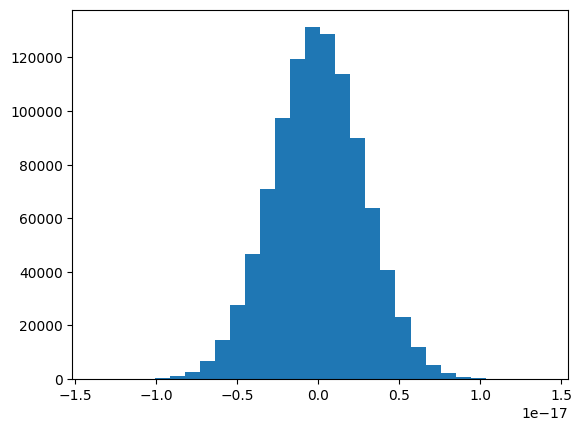

In [49]:
#freq, noise = generate_noise(70e6, 2e3, 4, 5e6, 1e6, 1e3)
freq, noise = white_noise(4, 5e6, get_bandwidth(500, 70e6), 100e3, 1e6)
#eplt.plot(freq/1e6, abs(noise))
plt.hist(noise.real, 30)
plt.show()

### Electron as LC circuit

We can model the electrons in the trap as series LC circuit following Wineland 1975.

In [11]:
def le(d, n, m=m, e=e):
    '''
    equivalent inductance of electron
    '''
    return m*d**2/e**2/n

def ce(omega, l, m=m, e=e):
    '''
    equivalent capacitance of electron
    '''
    return 1/(omega**2*l)

def get_lc(d, n, omega, m=m, e=e):
    l = le(d, n, m, e)
    c = ce(omega, l, m, e)
    return l, c

In [12]:
class HarmonicElectron(Component):
    def __init__(self, n, d, omega, m=m, e=e, name='Electron'):
        super().__init__(name=name, n=n, d=d, omega=omega, m=m, e=e)
        self.l, self.c = get_lc(d, n, omega, m, e)

    def get_lc(self):
        return self.l, self.c

In [13]:
electron = HarmonicElectron(1, 254e-6, omega=70e6*2*np.pi)
electron.c

2.2579199553814036e-18

### Tank circuit

We can model the tank circuit as an RLC circuit with lumped R and parallel LC. The value of R can be expressed in terms of $Q$ and $Z_0$ components as
$$ R = QZ_0$$
We also want to write $L$ and $C$ in terms of $\omega_0$ and $Z_0$ so we can just find everything based on the resonant frequency and desired $Z_0$ with
$$ Q = R\sqrt{\frac{C}{L}}, ~\omega_0 = \frac{1}{\sqrt{LC}} $$
and doing algebra yields
$$ L = \frac{R}{\omega_0 Q}, ~C = \frac{Q}{\omega_0 R} $$

In [14]:
def Rt(Q, Z0):
    return Q*Z0

def Ct(omega, Q, R):
    return Q/(omega*R)

def Lt(omega, Q, R):
    return R/(omega*Q)

def get_RLC(Q, Z0, omega):
    R = Rt(Q, Z0)
    L = Lt(omega, Q, R)
    C = Ct(omega, Q, R)
    return R, L, C

In [235]:
class TankCircuit(Component):
    def __init__(self, Q, Z0, omega_0, T=4, name='TankCircuit'):
        super().__init__(name=name, Q=Q, Z0=Z0, omega_0=omega_0, T=T)
        self.R, self.L, self.C = get_RLC(Q, Z0, omega_0)
        self.T = T

    def get_RLC(self):
        return self.R, self.L, self.C

    def get_noise(self, f):
        """
        Returns the power spectral density of the noise.
        """
        PSD = 4*kB*self.T*self.R
        return self.white_noise(f, PSD)

class HarmoincElectronCoupledTank(Component):
    def __init__(self, n, d, Q, Z0, omega_0, omega_z, 
                 m=m, e=e, T=4, name='Electron'):
        super().__init__(name=name, n=n, d=d, Q=Q, Z0=Z0,
                         omega_0=omega_0, omega_z=omega_z,
                         T=T, m=m, e=e)
        self.Electron = HarmonicElectron(n, d, omega_z, m, e, name)
        self.TankCircuit = TankCircuit(Q, Z0, omega_0, T, name)
        self.R, self.L, self.C = self.TankCircuit.get_RLC()
        self.l, self.c = self.Electron.get_lc()

    def H(self, omega):
        '''
        series lc (electron) coupled to a parallel RLC (tank circuit) circuit, see Wineland 1975
        '''
        s = 1j*omega
        s = 1j*omega
        Zl = s*self.l
        ZL = s*self.L
        Zc = 1/(s*self.c)
        ZC = 1/(s*self.C)
        R = self.R
        
        Zlc = parallel( (Zl+Zc), parallel(ZL, ZC) )
        return Zlc / (Zlc+R)

## Tests

### Transfer function plots

In [40]:
def U_tank(UR, omega, l, c, L, C, R):
    s = 1j*omega
    Zl = s*l
    ZL = s*L
    Zc = 1/(s*c)
    ZC = 1/(s*C)
    
    Zlc = parallel( (Zl+Zc), parallel(ZL, ZC) )
    #Zlc = parallel(ZL, ZC)
    H = Zlc / (Zlc+R)
    return UR * H

def find_width(x, y, threshold=0.5):
    i_min = np.argmin(y)
    i_max1 = np.argmax(y[:i_min])
    i_max2 = np.argmax(y[i_min:])+i_min
    i_thres1 = np.argmin(abs(y[i_max1:i_min]-threshold)) + i_max1
    i_thres2 = np.argmin(abs(y[i_min:i_max2]-threshold)) + i_min
    return x[i_thres2] - x[i_thres1]

def plot_H(n, d, Q, Z0, f0, fz=None, rg=0.3e3):
    omega_0 = 2*np.pi*f0
    if fz is None:
        fz = f0
    omega_z = 2*np.pi*fz
    freq = np.linspace(f0-rg, f0+rg, int(2*rg))
    tank_circuit = HarmoincElectronCoupledTank(n, d, Q, Z0, omega_0, omega_z, 
                                               m=m, e=e, name='Electron')
    y_tank = tank_circuit(freq, 1)**2
    freq_plot = (freq - f0)/1e3
    plot(freq_plot, y_tank)
    f0_plot = 0
    width_exp = tank_circuit.R/2/np.pi/tank_circuit.l
    plt.axvline(0, color='r', linestyle='--', alpha=0.7, label=f'$f_0$ = {omega_0/2e6/np.pi:.0f} MHz')
    if fz == f0:
        width = find_width(freq_plot, y_tank)
        width_plot = width
        plt.axvspan(f0_plot-width_plot/2, f0_plot+width_plot/2, color='y', alpha=0.3, label=f'$\Delta f_n$ = {width:.2f} KHz, expected {width_exp/1e3:.2f} KHz')
    else:
        plt.axvline((fz-f0)/1e3, color='orange', linestyle='--', alpha=0.7, label=f'$f_z=f_0 + {(fz-f0)/1e3:.0f}$ KHz')
        
    plt.xlabel('$f-f_0$ (KHz)')
    plt.ylabel('$|H|^2$')
    plt.legend()
    plt.tight_layout()

#### Single electron

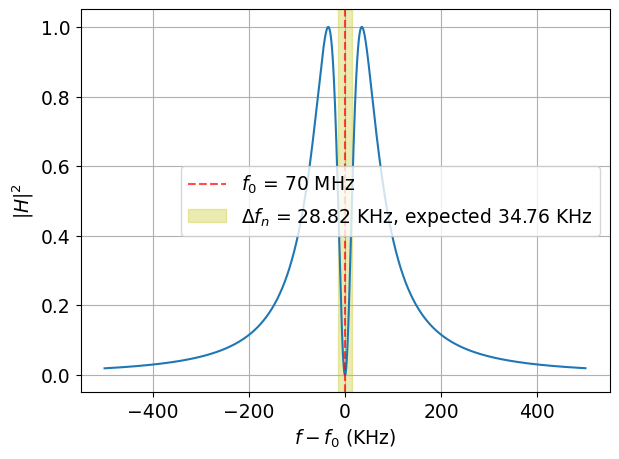

In [59]:
n = 1
d = 254e-6
Q = 500
Z0 = 1000
f0 = 70e6
fz = f0

plot_H(n, d, Q, Z0, f0, fz, rg=0.5e6)
plt.show()

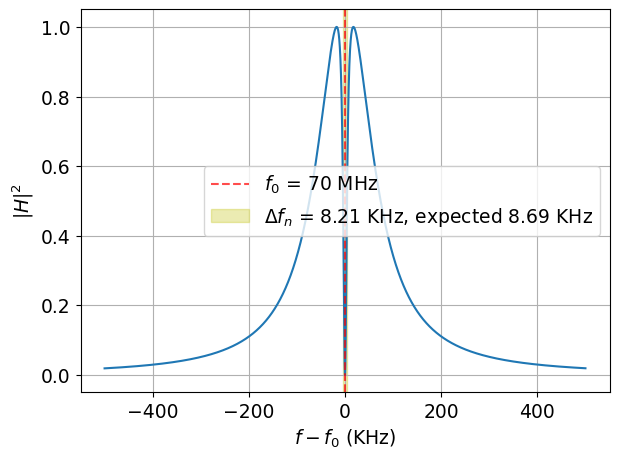

In [60]:
n = 1
d = 254e-6*2
Q = 500
Z0 = 1000
f0 = 70e6

plot_H(n, d, Q, Z0, f0, rg=0.5e6)
plt.show()

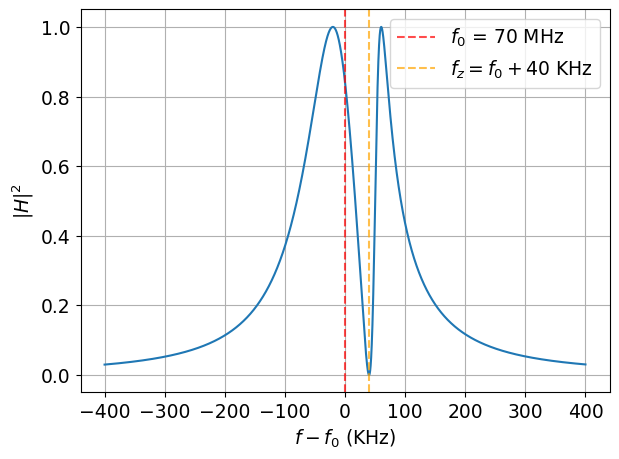

In [64]:
n = 1
d = 254e-6
Q = 500
Z0 = 1000
f0 = 70e6
fz = 70e6+40e3

plot_H(n, d, Q, Z0, f0, fz, rg=400e3)
plt.show()

#### Multiple electrons

C:\Users\electron\AppData\Local\Temp\ipykernel_66012\1550702305.py:45: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
C:\Users\electron\miniconda3\envs\e\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


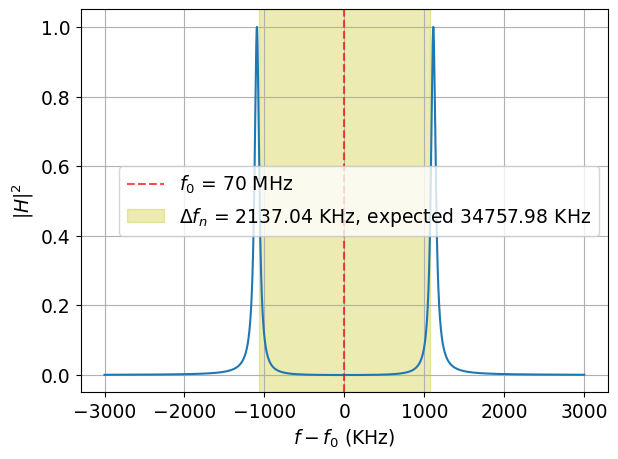

In [44]:
n = 1000
d = 254e-6
Q = 500
Z0 = 1000
f0 = 70e6

plot_H(n, d, Q, Z0, f0, rg=3000e3)
plt.show()

### Width vs trap parameters

Here we consider the "shunting width" of the electron coupled to the tank circuit given different parameters.

In [49]:
def find_width_param(n, d, Q, Z0, f0, fz=None, rg=0.3e3):
    omega_0 = 2*np.pi*f0
    if fz is None:
        fz = f0
    omega_z = 2*np.pi*fz
    tank_circuit = HarmoincElectronCoupledTank(n, d, Q, Z0, omega_0, omega_z, 
                                               m=m, e=e, name='Electron')
    width_exp = tank_circuit.R/2/np.pi/tank_circuit.l
    return width_exp

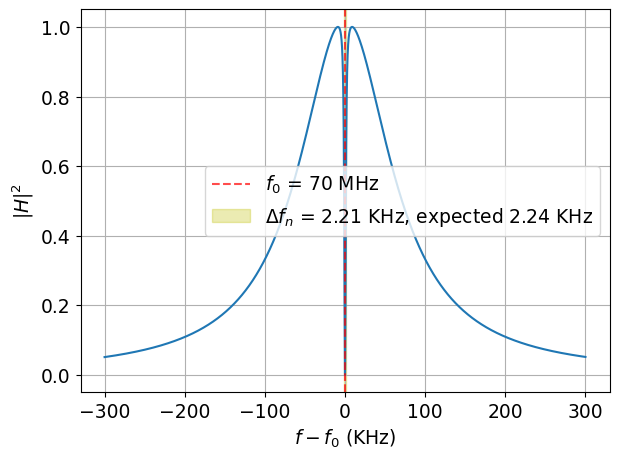

In [46]:
n = 1
d = 1e-3
Q = 500
Z0 = 1000
f0 = 70e6

plot_H(n, d, Q, Z0, f0, rg=300e3)
plt.show()

In [294]:
def plot_heatmap(ra, rb, f, clabel, xlabel=None, ylabel=None,
                 xfactor=1, yfactor=1,
                 xscale='log', yscale='log'):
    # Generate grids for a and b
    A, B = np.meshgrid(ra, rb)
    
    # Evaluate the function f for all combinations of a and b
    Z = np.zeros_like(A)
    for i in trange(len(ra)):
        for j in range(len(rb)):
            Z[j, i] = f(ra[i], rb[j])
    
    # Plot heatmap
    plt.figure(figsize=(8, 6))
    plt.imshow(Z, extent=[min(ra)*xfactor, 
                          max(ra)*xfactor, 
                          min(rb)*yfactor, 
                          max(rb)*yfactor], 
               origin='lower', aspect='auto')
    plt.colorbar(label=clabel)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xscale(xscale)
    plt.yscale(yscale)
    plt.title('2D Heatmap of f(a, b)')
    plt.show()

100%|██████████| 10/10 [00:01<00:00,  8.06it/s]


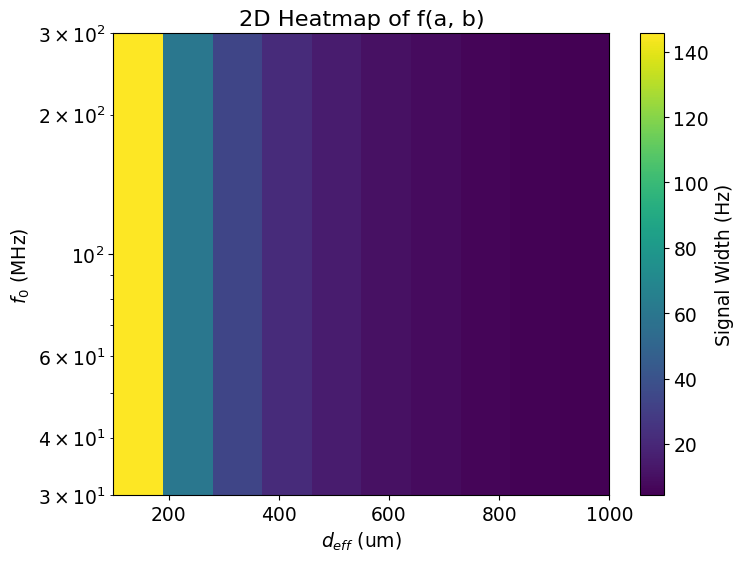

In [298]:
d_range = np.linspace(100e-6, 1e-3, 10)
f_range = 3*np.logspace(7, 8, 10)
plot_heatmap(d_range, f_range, 
             lambda d, f: find_width_param(n, d, Q, Z0, f0), 
             clabel='Signal Width (Hz)', xlabel='$d_{eff}$ (um)', ylabel='$f_0$ (MHz)',
             xfactor=1e6, yfactor=1e-6, xscale='linear')

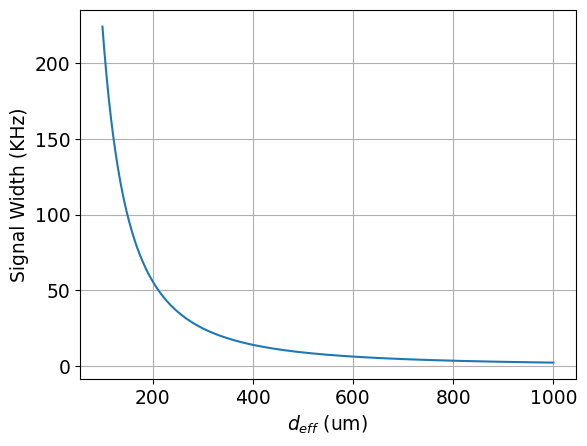

In [53]:
d_range = np.linspace(100e-6, 1e-3, 1000)
all_width = np.array([find_width_param(n, di, Q, Z0, f0) for di in d_range])
plot(d_range*1e6, all_width/1e3, xlabel='$d_{eff}$ (um)', ylabel='Signal Width (KHz)')

### Signal to noise ratio

Following Wineland 1975 Eq. 5.2-5.4, we here consider the case where the electron(s) is excited by a small amount of heat inputs $\Delta T \ll T_0$, where $T_{R1}=T_0$ represents the temperature for the axial heat reservoir, and $T_I=T_0+\Delta T$ denotes the internal temperature of the electron after a small excitation. Then we have the expression for S/N as
$$\frac{S}{N} = \frac{\bar{u_s^2}(T_I > T_0) - \bar{u_s^2}(T_I = T_0)}{\bar{u_s^2}(T_I=T_0)}\sqrt{\frac{\Delta f_1}{2\Delta f_2}},$$
where $\bar{u_s^2}$ represents the signal voltage rms, $\Delta f_1$ is the bandwidth of the flat filter after the mixer and $\Delta f_2$ is the bandwidth of the flat filter after the square-law detection, or $\Delta f_2 = 1/(4R_fC_f)$ if a simple low-pass filter is used.
<div>
<center><img src="images/Detection_circuit_wineland1975.png" "Model for electrons interacting with trap circuit showing block diagram of detection electronics" width="400"/>
<div>

Here, $R_e$ is assumed to be small, and we want large $\Delta f_1$ but sill ensuring small $R_e$. In addition, the circuit above is obtained when $2\pi(f_z-f_z')\equiv \delta \gg 1/RC$, where $f_z'$ is the center frequency for the tank circuit, i.e. the electron is far detuned from the tank circuit by $\delta$. In this notation, the effective series-resistance is $R_\delta = R/(2\delta RC)^2$ and $C_\delta = 2\delta C/\omega_z$. On the other hand, if the electron is on resonance, $C_\delta \rightarrow \infty$ and $R_\delta = R$, so the circuit just reduces to electron LC circuit connected to a resonant impedence $R$, as expected.

Now we can consider two cases to simplify the expression:

(1) electron off-resonance with tank circuit (e-parallel resonance) 
    $$\frac{S}{N} = \frac{\Delta T}{T_0}\sqrt{\frac{\Delta f_z}{2\Delta f_2}}, $$
where $\Delta f_z$ is the linewidth of the CM mode determined by the coupling strength to the *axial internal modes*, with the form $\Delta f_z = \gamma_z/2\pi$ and $\gamma_z = 1/\tau_z$.
<div>
<center><img src="images/electrons_coupled_mode_structures_wineland1975.png" "Model thermal coupling schemes for electrons in a Penning trap." width="400"/>
<div>
    
(2) electron on-resonance with the tank circuit (e-serise resonance)
    $$\frac{S}{N} \approx \frac{\Delta T}{T_0}\frac{(\Delta f_z\Delta f_{n1})^{1/4}}{(2\Delta f_2)^{1/2}},$$
where $\Delta f_{n1} = \Delta f_R$ is the width of the tank circuit.
    
**Now after writing all of these I realized that this treatment may not be as useful for single electrons... so here we chose a simpler way to model S/N below.**

We know that the current resulted from the electron at temperature $T$ follows 
$$\bar{i}_{CM}^2 = nk_B T/l_1 = \frac{ne^2k_BT}{md_{eff}^2}$$
and the noise
$$\bar{i}_{JN}^2 = 4k_BTR\Delta f$$

In [194]:
def moving_avg(y, window, display_progress=True):
    """
    Calculate the moving average of y values based on the specified window size.
    
    Parameters:
        x (list or numpy array): The x values.
        y (list or numpy array): The y values.
        window (int): The size of the moving average window.
        
    Returns:
        list: The moving average of y values.
    """
    moving_avg = []
    for i in trange(len(y), desc='Measuring Signal', disable=(not display_progress)):
        if i >= window - 1:
            avg = sum(y[i - window + 1:i + 1]) / window
            moving_avg.append(avg)
        else:
            moving_avg.append(sum(y[:i + 1])/(i+1))
    return np.array(moving_avg)

class ElectronCoupledToTank(Component):
    def __init__(self, Electron, TankCircuit, name='Tank Circuit'):
        super().__init__(name=name, Electron=Electron, TankCircuit=TankCircuit)
        self.Electron = Electron
        self.TankCircuit = TankCircuit
        self.l, self.c = Electron.get_lc()
        self.R, self.L, self.C = TankCircuit.get_RLC()

    def H(self, omega):
        s = 1j*omega
        s = 1j*omega
        Zl = s*self.l
        ZL = s*self.L
        Zc = 1/(s*self.c)
        ZC = 1/(s*self.C)
        R = self.R
        
        Zlc = parallel( (Zl+Zc), parallel(ZL, ZC) )
        return Zlc / (Zlc+R)

class SpectrumAnalyzer(Component):
    def __init__(self, noise_psd, BW_measurement, Z_measurement, 
                 display_progress=True, name='Spectrum Analyzer'):
        super().__init__(name=name, noise_psd=noise_psd, 
                         Z_measurement=Z_measurement, 
                         BW_measurement=BW_measurement,
                         display_progress=display_progress)

    def __call__(self, f, signal):
        window_size = int(self.BW_measurement/(f[1]-f[0]))
        noise_floor = self.white_noise(f, self.noise_psd)
        output_signal = (signal + noise_floor)*self.BW_measurement/self.Z_measurement  # Power spectrum
        self.noise_floor = W_to_dBm(noise_floor*self.BW_measurement)
        if window_size <= 1:
            return W_to_dBm(output_signal)
        else:
            return W_to_dBm(moving_avg(output_signal, window_size, display_progress=self.display_progress))

class HEMT(Component):
    def __init__(self, gain, voltage_noise, name='Amplifier'):
        super().__init__(name=name, gain=gain, voltage_noise=voltage_noise)

    def get_noise(self, f):
        psd = self.voltage_noise**2
        return self.white_noise(f, psd)

    def __call__(self, f, signal):
        noise = self.get_noise(f)
        return self.gain**2 * (signal + noise)

In [413]:
def ie2(T, d, n=1):
    return n*e**2*kB*T/m/d**2

def ve2(T, d, R, n=1):
    return ie2(T, d, n)*R**2

def iJN2(T, R, df):
    return 4*kB*T/R*df

def vJN2(T, R, df):
    return R**2*iJN2(T, R, df)

def dB(frac):
    return 10*np.log10(frac)

def frac(dB):
    return 10**(dB/10)

In [414]:
d = 254e-6
#Tres = np.linspace(4, 400, 10000)
Tres = 4
R = 30e3
Q = 500
f0 = 70e6
Te = Tres

#Te = np.linspace(4, 400, 10000)
v2_signal = ve2(Te, d, R)
v2_tank_JN = vJN2(Tres, R, f0/Q)
SNR0 = v2_signal/v2_tank_JN
SNR0_dB = 10*np.log10(SNR0)
#plot(Te, SNR_dB)
print(f'SNR after tank circuit: {SNR0_dB:.2f}dB')

v_amp_noise1 = 1e-9
G_amp_dB = 20
f_filter = 70e6
Q_filter = 6

filter_width = f_filter/Q_filter
G_amp = frac(G_amp_dB)
v2_amp_noise = v_amp_noise1**2*filter_width

v2_amp_out_noise = G_amp**2*v2_tank_JN + v2_amp_noise
print(np.sqrt(v2_amp_out_noise/filter_width))
v2_amp_out_signal = G_amp**2*v2_signal
SNR1 = v2_amp_out_signal / v2_amp_out_noise
SNR1_dB = dB(SNR1)
print(f'SNR after amplifier: {SNR1_dB:.2f}dB')

SNR after tank circuit: -16.31dB
2.821796987736715e-08
SNR after amplifier: -16.31dB


In [71]:
def plot_H(n, d, Q, Z0, f0, T, R, BW_meas,
           HEMT_noise, G_amp, noise_meas,
           fz=None, rg=0.3e3):
    omega_0 = 2*np.pi*f0
    if fz is None:
        fz = f0
    omega_z = 2*np.pi*fz
    freq = np.linspace(f0-rg, f0+rg, int(2*rg)
                      )
    l, c = get_lc(d, n, omega_z)
    R, L, C = get_RLC(Q, Z0, omega_0)
    
    print(R*(2*(fz-f0)*R*C)**(-2)/(2*np.pi*l))
    
    #freq_noise, U_JN = white_noise(T, R, f0/Q, resolution=100e3, samples=1e6)
    U2_JN = 4*kB*T*R*BW_meas
    U2_Re = HEMT_noise**2*BW_meas
    y_tank = abs(U_tank(1, 2*np.pi*freq, l, c, L, C, R))**2*U2_JN + U2_Re
    freq_plot = freq - f0
    yf = moving_avg(y_tank, int(BW_meas/(freq_plot[1]-freq_plot[0])))
    plot(freq_plot, yf)
    f0_plot = 0
   
    plt.axvline(0, color='r', linestyle='--', alpha=0.7, label=f'$f_0$ = {omega_0/2e6/np.pi:.0f} MHz')
    '''
    if fz == f0:
        width = find_width(freq_plot, y_tank)
        width_plot = width
        plt.axvspan(f0_plot-width_plot/2, f0_plot+width_plot/2, color='y', alpha=0.3, label=f'$\Delta f_n$ = {width:.2f} Hz')
    else:
        plt.axvline(fz-f0, color='orange', linestyle='--', alpha=0.7, label=f'$f_z=f_0 + {fz-f0:.0f}$ Hz')
    '''
    plt.xlabel('$f-f_0$ (Hz)')
    plt.ylabel('$|V|^2$')
    plt.legend()
    plt.tight_layout()
    return freq_plot, yf

In [ ]:
def plot_power(n, d, Q, Z0, f0, fz=None, rg=0.3e3):
    omega_0 = 2*np.pi*f0
    if fz is None:
        fz = f0
    omega_z = 2*np.pi*fz
    freq = np.linspace(f0-rg, f0+rg, int(2*rg))
    tank_circuit = HarmoincElectronCoupledTank(n, d, Q, Z0, omega_0, omega_z, 
                                               m=m, e=e, name='Electron')
    y_tank = tank_circuit(freq, 1)**2
    freq_plot = (freq - f0)/1e3
    plot(freq_plot, y_tank)
    f0_plot = 0
    width_exp = tank_circuit.R/2/np.pi/tank_circuit.l
    plt.axvline(0, color='r', linestyle='--', alpha=0.7, label=f'$f_0$ = {omega_0/2e6/np.pi:.0f} MHz')
    if fz == f0:
        width = find_width(freq_plot, y_tank)
        width_plot = width
        plt.axvspan(f0_plot-width_plot/2, f0_plot+width_plot/2, color='y', alpha=0.3, label=f'$\Delta f_n$ = {width:.2f} KHz, expected {width_exp/1e3:.2f} KHz')
    else:
        plt.axvline((fz-f0)/1e3, color='orange', linestyle='--', alpha=0.7, label=f'$f_z=f_0 + {(fz-f0)/1e3:.0f}$ KHz')
        
    plt.xlabel('$f-f_0$ (KHz)')
    plt.ylabel('$|H|^2$')
    plt.legend()
    plt.tight_layout()

C:\Users\electron\AppData\Local\Temp\ipykernel_66012\1877120329.py:2: RuntimeWarning: divide by zero encountered in log10
  return 10*np.log10(1000*W)
Measuring Signal: 100%|██████████| 400000/400000 [00:04<00:00, 93243.16it/s]
C:\Users\electron\AppData\Local\Temp\ipykernel_66012\1877120329.py:2: RuntimeWarning: invalid value encountered in log10
  return 10*np.log10(1000*W)
Measuring Signal: 100%|██████████| 400000/400000 [00:04<00:00, 95040.53it/s]


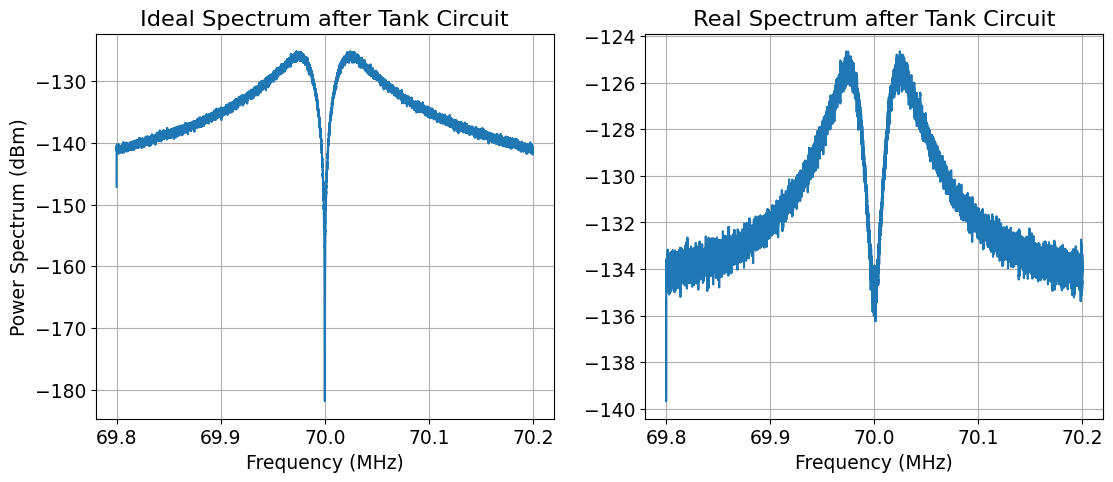

Measuring Signal: 100%|██████████| 400000/400000 [00:04<00:00, 95218.80it/s]


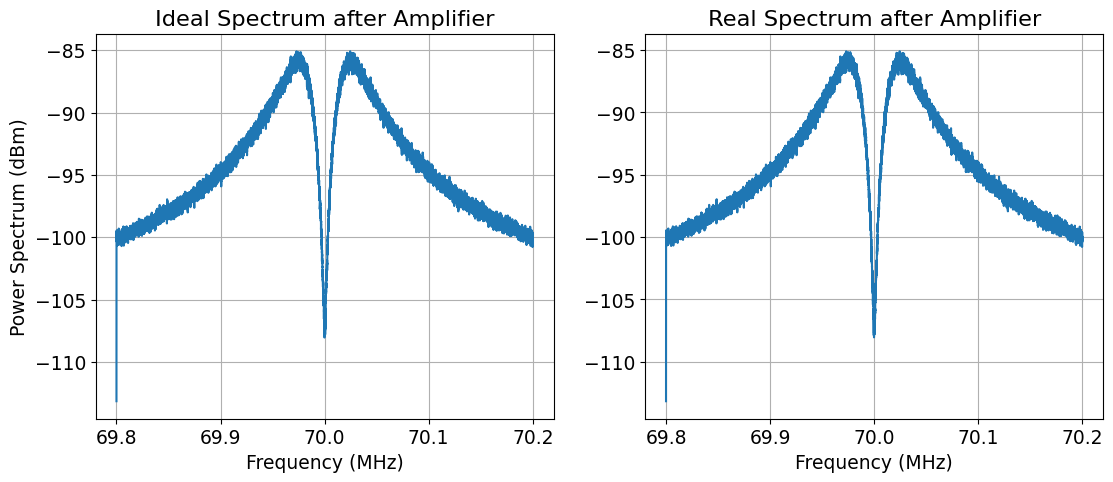

Measuring Signal: 100%|██████████| 400000/400000 [00:04<00:00, 97608.29it/s] 


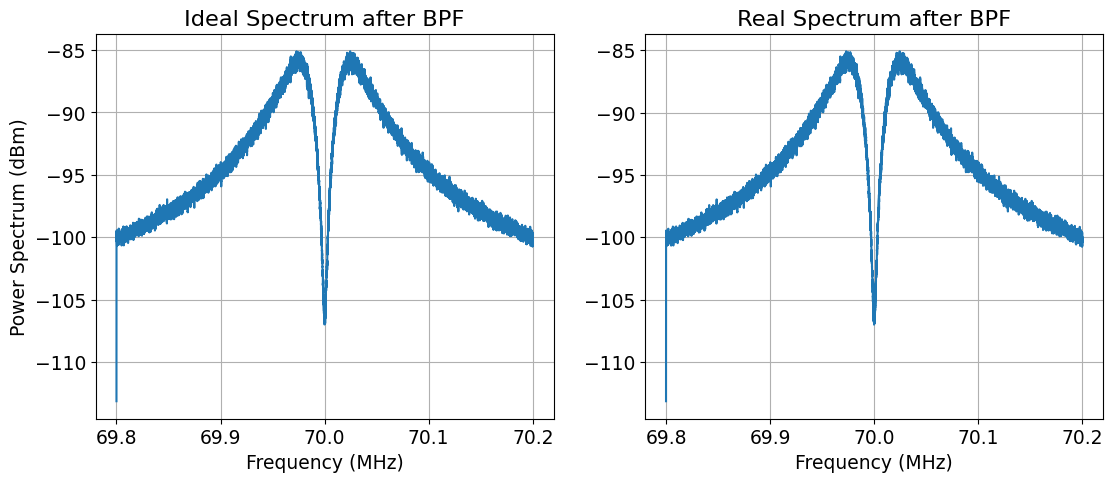

Measuring Signal: 100%|██████████| 400000/400000 [00:04<00:00, 95432.87it/s] 


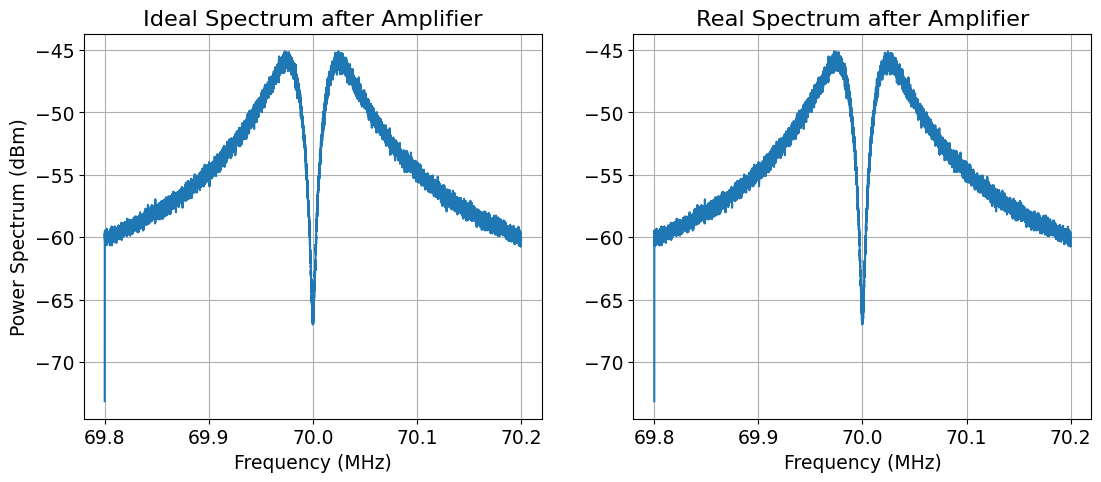

In [234]:
n = 1  # number of electrons
d = 254e-6  # effective distance, in m
Q = 1000  # quality factor of tank circuit
Z0 = 500  # characteristic impedance of the tank circuit, in Ohm
f0 = 70e6  # resonant frequency of the tank circuit, in Hz (NOT angular freq)
fz = 70e6  # motional frequency of the electron (resonant freq of the series lc), in Hz (NOT angular freq)
T = 4  # temperature of the tank circuit, in K
R = Q*Z0  # on resonance effective resistance of the tank circuit

noise_preamp = 1e-9  # V^2/sqrt(Hz), noise level of the amplifier
G_preamp = dB_to_frac(20)  # Decimal, amplification factor of the amplifier
noise_hemt = 1e-9  # V^2/sqrt(Hz), noise level of the amplifier
G_hemt = dB_to_frac(20)  # Decimal, amplification factor of the amplifier

BW_meas = 100  # Hz, measurement bandwidth
Z_meas = 50  # Ohm, measurement impedance
noise_floor = dBm_to_W(-135)*Z_meas/BW_meas  # V^2/sqrt(Hz), noise floor of the spectrum analyzer
plot_rg = 0.2e6  # Hz, plotting range

plot_intermediate = True

electron = HarmonicElectron(n, d, 2*np.pi*fz, m, e)
tank_circuit = TankCircuit(Q, Z0, 2*np.pi*f0, T)
electron_trap = ElectronCoupledToTank(electron, tank_circuit)
spectrum_analyzer = SpectrumAnalyzer(noise_floor, BW_meas, Z_meas)
noiseless_spectrum_analyzer = SpectrumAnalyzer(0, BW_meas, Z_meas)
pre_amp = HEMT(G_preamp, noise_preamp)
bpf1 = BandPassFilter(2*np.pi*f0, Q=6)
buffer_amp = HEMT(G_hemt, noise_hemt)

freq = np.linspace(f0-plot_rg, f0+plot_rg, int(2*plot_rg))
all_devices = [electron_trap, pre_amp, bpf1, buffer_amp]
psd_signal = tank_circuit.get_noise(freq)

for device in all_devices:
    psd_signal = device(freq, psd_signal)
    ideal_ps = noiseless_spectrum_analyzer(freq, psd_signal)
    real_ps = spectrum_analyzer(freq, psd_signal)
    
    if plot_intermediate:
        fig, ax = plt.subplots(ncols=2, figsize=(13, 5))
        plot_ax(ax[0], freq/1e6, ideal_ps, xlabel='Frequency (MHz)', ylabel='Power Spectrum (dBm)', title=f'Ideal Spectrum after {device.name}')
        plot_ax(ax[1], freq/1e6, real_ps, xlabel='Frequency (MHz)', title=f'Real Spectrum after {device.name}')
        plt.show()

### Anharmonicity

In [262]:
n = 1
d = 254e-6  # m
Q = 1000
Z0 = 500  # Ohm
f0 = 70e6  # Hz
fz_0 = 70e6  # Hz
delta_fz = fz_0 * 1e-4  # Hz
T = 4  # K
R = Q*Z0

noise_preamp = 1e-9  # V^2/sqrt(Hz)
G_preamp = dB_to_frac(20)  # Decimal
noise_hemt = 1e-9  # V^2/sqrt(Hz)
G_hemt = dB_to_frac(20)  # Decimal

BW_meas = 100  # Hz
Z_meas = 50  # Ohm
noise_floor = dBm_to_W(-135)*Z_meas/BW_meas  # V^2/sqrt(Hz)
plot_rg = 0.2e6

plot_intermediate = False
display_progress = False
N_electron_freq = 32

freq = np.linspace(f0-plot_rg, f0+plot_rg, int(2*plot_rg)//10)
output_ideal_spectrum = np.zeros(np.shape(freq))
output_real_spectrum = np.zeros(np.shape(freq))
all_fz = fz_0 + np.linspace(-3*delta_fz, 3*delta_fz, N_electron_freq)
Pz = sp.stats.norm.pdf((all_fz-fz_0)/delta_fz)
Pz_norm = Pz / np.sum(Pz)


tank_circuit = TankCircuit(Q, Z0, 2*np.pi*f0, T)
spectrum_analyzer = SpectrumAnalyzer(noise_floor, BW_meas, Z_meas, display_progress=display_progress)
noiseless_spectrum_analyzer = SpectrumAnalyzer(0, BW_meas, Z_meas, display_progress=False)
pre_amp = HEMT(G_preamp, noise_preamp)
bpf1 = BandPassFilter(2*np.pi*f0, Q=6)
buffer_amp = HEMT(G_hemt, noise_hemt)

for idx in trange(len(all_fz)):
    fz = all_fz[idx]
    electron = HarmonicElectron(n, d, 2*np.pi*fz, m, e)
    electron_trap = ElectronCoupledToTank(electron, tank_circuit)
    
    all_devices = [electron_trap, pre_amp, bpf1, buffer_amp]
    psd_signal = tank_circuit.get_noise(freq)
    
    for device in all_devices:
        psd_signal = device(freq, psd_signal)
        ideal_ps = noiseless_spectrum_analyzer(freq, psd_signal)
        real_ps = spectrum_analyzer(freq, psd_signal)
        
        if plot_intermediate:
            fig, ax = plt.subplots(ncols=2, figsize=(13, 5))
            plot_ax(ax[0], freq/1e6, ideal_ps, xlabel='Frequency (MHz)', ylabel='Power Spectrum (dBm)', title=f'Ideal Spectrum after {device.name}')
            plot_ax(ax[1], freq/1e6, real_ps, xlabel='Frequency (MHz)', title=f'Real Spectrum after {device.name}')
            plt.show()
    output_ideal_spectrum += dBm_to_W(ideal_ps) * Pz_norm[idx]
    output_real_spectrum += dBm_to_W(real_ps) * Pz_norm[idx]

  0%|          | 0/32 [00:00<?, ?it/s]C:\Users\electron\AppData\Local\Temp\ipykernel_66012\1877120329.py:2: RuntimeWarning: divide by zero encountered in log10
  return 10*np.log10(1000*W)
C:\Users\electron\AppData\Local\Temp\ipykernel_66012\1877120329.py:2: RuntimeWarning: invalid value encountered in log10
  return 10*np.log10(1000*W)
100%|██████████| 32/32 [00:25<00:00,  1.25it/s]


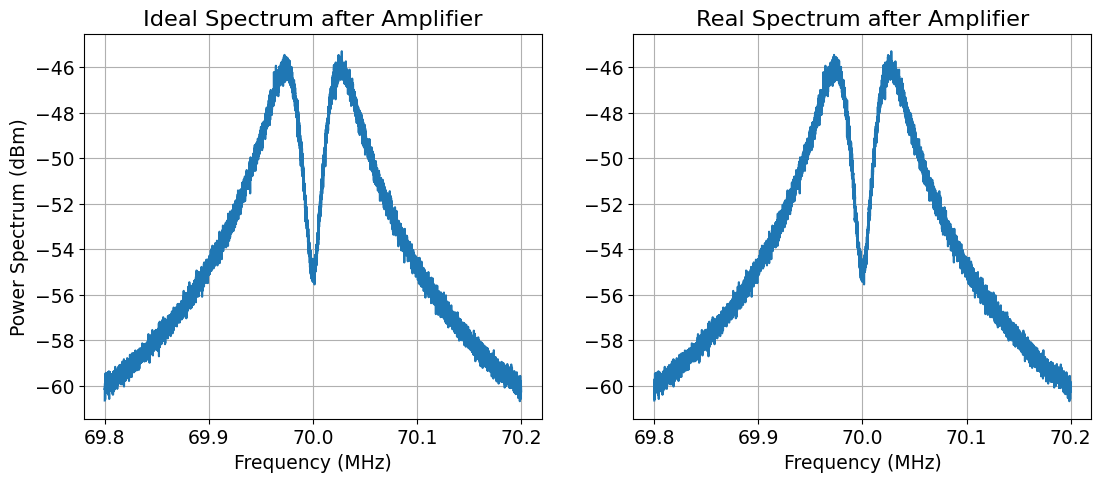

In [263]:
fig, ax = plt.subplots(ncols=2, figsize=(13, 5))
plot_ax(ax[0], freq/1e6, W_to_dBm(output_ideal_spectrum), xlabel='Frequency (MHz)', ylabel='Power Spectrum (dBm)', title=f'Ideal Spectrum after {device.name}')
plot_ax(ax[1], freq/1e6, W_to_dBm(output_real_spectrum), xlabel='Frequency (MHz)', title=f'Real Spectrum after {device.name}')
plt.show()

In [150]:
W_to_dBm((1e-9)**2*BW_meas/50)
voltage_noise_to_dBm(1e-9, 100, 50)

-146.9897000433602

## Varying trap parameters

In [13]:
class DetectionSetup(Component):
    def __init__(self, BW_measurement, Z_measurement, noise_floor, 
                 display_progress=False, name='DetectionSetup', 
                 **kwargs):
        super().__init__(name=name, BW_measurement=BW_measurement, 
                         Z_measurement=Z_measurement, **kwargs)
        self.spectrum_analyzer = SpectrumAnalyzer(noise_floor, BW_meas, Z_meas, 
                                                  display_progress=display_progress)
        self.noiseless_spectrum_analyzer = SpectrumAnalyzer(0, BW_meas, Z_meas, 
                                                            display_progress=False)
        
    def measure_spectrum(self, freq, psd_signal):
        """
        Measure the power spectrum of the signal using a spectrum analyzer
        with a defined noise floor and an ideal spectum analyzer with 0 noise.
        """
        ideal_spectrum = self.noiseless_spectrum_analyzer(freq, psd_signal)
        real_spectrum = self.spectrum_analyzer(freq, psd_signal)
        return ideal_spectrum, real_spectrum
        

class AnharmonicElectronSetup(DetectionSetup):
    def __init__(self, n, d, Q, Z0, f0, fz_0, delta_fz, T, 
                 BW_measurement, Z_measurement, noise_floor, 
                 N_average, m=m, e=e,
                 devices=[],
                 display_progress=False, 
                 name='AnharmonicElectron'):
        """
        The electron coupled to a tank circuit. A finite width is assumed
        and the electron's motional spectrum has a Gaussian distribution
        with width delta_fz (std = delta_fz/2).

        Parameters
        ----------
        n : int
            Number of electrons 
        d : [m]
            Effective distance
        m : [kg]
            Mass of electron
        e : [c]
            Magnitude of the charge of electron
        Q : int
            Quality factor of tank circuit
        Z0 : [Ohm]
            Characteristic impedance of the tank circuit
        f0 : [Hz]
            Resonant frequency of the tank circuit, 
            in Hz (NOT angular freq)
        fz_0 : [Hz]
            Motional frequency of the electron (resonant 
            freq of the series lc), in Hz (NOT angular freq)
        delta_fz : [Hz]
            Width of the motional frequency of the electron,
            where the motional frequency is assumed to have a
            Gaussian distribution with std = width/2
        T : [K]
            Temperature of the tank circuit
        BW_measurement : [Hz]
            Measurement bandwidth of the spectrum analyzer
        Z_measurement : [Ohm]
            The measurement impedance of the spectrum analyzer
        noise_floor : [V^2/Hz]
            The noise power spectral density of the spectrum analyzer
        N_average : int
            The number of shots to take and do averaging on
        devices : list
            A list of devices in the detection setup, e.g. 
            amplifiers, filters, etc.
        display_progress : bool
            Whether to display a progress bar when doing 
            moving average on the signal
        """
        super().__init__(BW_measurement, Z_measurement, noise_floor, 
                         name=name, n=n, d=d, Q=Q, Z0=Z0, f0=f0, 
                         fz_0=fz_0, delta_fz=delta_fz, 
                         m=m, e=e, T=T, N_average=N_average,
                         display_progress=display_progress)
        self.devices = devices
        self.tank_circuit = TankCircuit(Q, Z0, 2*np.pi*f0, T)
        
    def __call__(self, freq):
        output_ideal_spectrum = np.zeros(np.shape(freq))
        output_real_spectrum = np.zeros(np.shape(freq))

        delta_fz = self.delta_fz
        N_average = self.N_average
        n = self.n
        d = self.d
        m = self.m
        e = self.e
        delta_fz = self.delta_fz
        fz_0 = self.fz_0
        tank_circuit = self.tank_circuit

        std = delta_fz/2
        all_fz = fz_0 + np.linspace(-3*std, 3*std, N_average)
        Pz = sp.stats.norm.pdf((all_fz-fz_0)/delta_fz)
        Pz_norm = Pz / np.sum(Pz)
        
        for idx in trange(len(all_fz)):
            fz = all_fz[idx]
            electron = HarmonicElectron(n, d, 2*np.pi*fz, m, e)
            electron_trap = ElectronCoupledToTank(electron, tank_circuit)
            
            psd_input = tank_circuit.get_noise(freq)
            psd_signal = electron_trap(freq, psd_input)
            
            for device in self.devices:
                psd_signal = device(freq, psd_signal)
            
            ideal_ps, real_ps = self.measure_spectrum(freq, psd_signal)
            output_ideal_spectrum += dBm_to_W(ideal_ps) * Pz_norm[idx]
            output_real_spectrum += dBm_to_W(real_ps) * Pz_norm[idx]
        return W_to_dBm(output_ideal_spectrum), W_to_dBm(output_real_spectrum)

In [239]:
def plot_power_spectrum(freq, ideal_ps, real_ps):
    fig, ax = plt.subplots(ncols=2, figsize=(13, 5))
    plot_ax(ax[0], freq/1e6, ideal_ps, xlabel='Frequency (MHz)', ylabel='Power Spectrum (dBm)', title='Ideal Spectrum')
    plot_ax(ax[1], freq/1e6, real_ps, xlabel='Frequency (MHz)', title='Real Spectrum')

In [259]:
n = 1  # number of electrons
d = 254e-6  # effective distance, in m
Q = 1000  # quality factor of tank circuit
Z0 = 500  # characteristic impedance of the tank circuit, in Ohm
f0 = 70e6  # resonant frequency of the tank circuit, in Hz (NOT angular freq)
fz_0 = 70e6  # motional frequency of the electron (resonant freq of the series lc), in Hz (NOT angular freq)
delta_fz = fz_0 * 1e-4  # Width of the motional frequency of the electron
T = 4  # temperature of the tank circuit, in K

noise_preamp = 1e-9  # V^2/sqrt(Hz), noise level of the amplifier
G_preamp = dB_to_frac(20)  # Decimal, amplification factor of the amplifier
noise_hemt = 1e-9  # V^2/sqrt(Hz), noise level of the amplifier
G_hemt = dB_to_frac(20)  # Decimal, amplification factor of the amplifier

BW_meas = 100  # Hz, measurement bandwidth
Z_meas = 50  # Ohm, measurement impedance
noise_floor = dBm_to_W(-135)*Z_meas/BW_meas  # V^2/sqrt(Hz), noise floor of the spectrum analyzer
plot_rg = 0.2e6  # Hz, plotting range
display_progress = False
N_average = 32  # The number of shots to take and do averaging on


pre_amp = HEMT(G_preamp, noise_preamp)
bpf1 = BandPassFilter(2*np.pi*f0, Q=6)
buffer_amp = HEMT(G_hemt, noise_hemt)
devices = [pre_amp, bpf1, buffer_amp]

freq = np.linspace(f0-plot_rg, f0+plot_rg, int(2*plot_rg)//10)
gaussian_electron = AnharmonicElectronSetup(n, d, Q, Z0, f0, fz_0, 
                                            delta_fz, T,
                                            BW_meas, Z_meas, noise_floor,
                                            N_average, m, e, devices, 
                                            display_progress)

In [260]:
ideal_spectrum, real_spectrum = gaussian_electron(freq)

  0%|          | 0/32 [00:00<?, ?it/s]C:\Users\electron\AppData\Local\Temp\ipykernel_66012\1877120329.py:2: RuntimeWarning: divide by zero encountered in log10
  return 10*np.log10(1000*W)
C:\Users\electron\AppData\Local\Temp\ipykernel_66012\1877120329.py:2: RuntimeWarning: invalid value encountered in log10
  return 10*np.log10(1000*W)
100%|██████████| 32/32 [00:06<00:00,  4.89it/s]


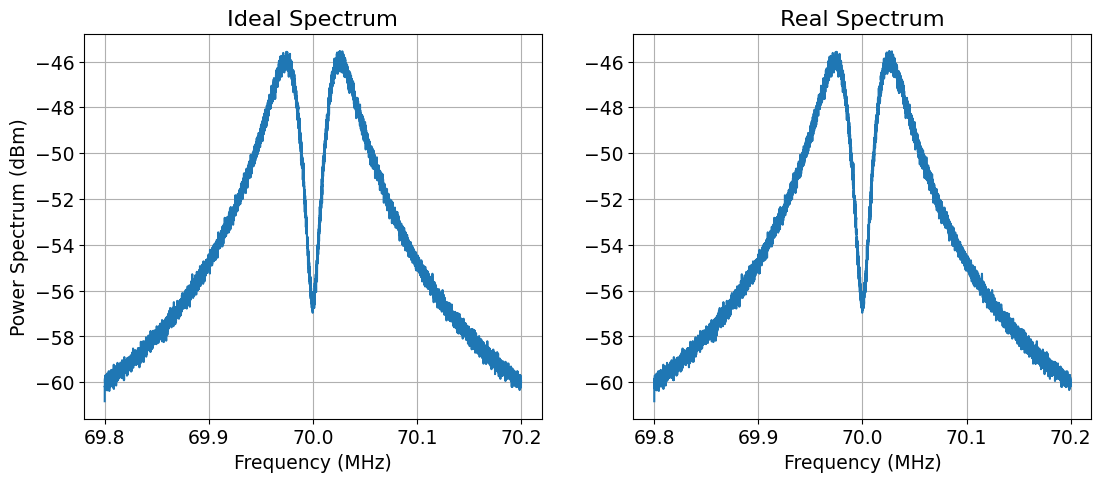

In [261]:
plot_power_spectrum(freq, ideal_spectrum, real_spectrum)

In [264]:
def find_SNR(x, y):
    i_min = len(y)//2
    i_max1 = np.argmax(y[:i_min])
    i_max2 = np.argmax(y[i_min:])+i_min
    y_min = np.min(y[i_max1:i_max2])
    y_max = np.max(y)
    return y_max - y_min

In [265]:
find_SNR(freq, real_spectrum)

11.41964441672134

In [266]:
dB_to_frac(11.42)

13.867558288718882